<img src = "https://storage.googleapis.com/kaggle-datasets-images/1019790/1719283/f7505a4e4d6e9c141aa2196a7a77ddf7/data-original.png?t=2020-12-07-00-41-54" height = "350" width="800">
 
 # <font color='blue'> HR Analytics: Job Change of Data Scientists </font> 
 
 
 In this project, we will use the CRISP-DM (Cross-Industrie Standard Process for Data Mining) to predict job change of data scientists in a particular company. We use this framework in order to work with a robust and well-proven methodology. Each stage of this framework will be describe in details belong this project.
 
 
## Business Understanding
 

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

## Data Understanding

This data is taken from Kaggle repository and can be downloaded in https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists. The dataset is designed to understand the factors that lead a person to leave current job for HR researches too. By a model that uses the current credentials, demographics, experience data we need to predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks.

**Note:**

The dataset is imbalanced.
Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
Missing imputation is part of our pipeline as well.

**Features**

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

Importing libraries and functions to be used.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew, boxcox
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, plot_confusion_matrix, auc

### Describe data 

Loading of training and test data sets.

In [2]:
train_data = pd.read_csv('aug_train.csv')
test_data = pd.read_csv('aug_test.csv')
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
print('Size of train_data')
print('  Number of rows:', len(train_data), '\n  Number of columns:', len(train_data.columns))
print('Size of test_data')
print('  Number of rows:', len(test_data), '\n  Number of columns:', len(test_data.columns))

Size of train_data
  Number of rows: 19158 
  Number of columns: 14
Size of test_data
  Number of rows: 2129 
  Number of columns: 13


Note that our test data doesn't have the column "target", so we have to fill it along our work. We observed that the size of the test data set corresponds to 11,11% of the size of the training data. In order to work correctly with our data, we will look at the type of the variables, without consider Nan values.

In [4]:
print("Train Data INFO \n")
train_data.info()

Train Data INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64

The variable target is consider as a float variable, and that doesn't make sense. To fix it, we change their type to integer.

In [5]:
train_data.target = train_data.target.astype(int)

### Explore data

Our goal in this section is to look at how variables can be related with each other. In the first moment, we will display some data visualizations, in order to figure out some patterns in our data. At the second moment, we use the target value to looking for some tendencys.

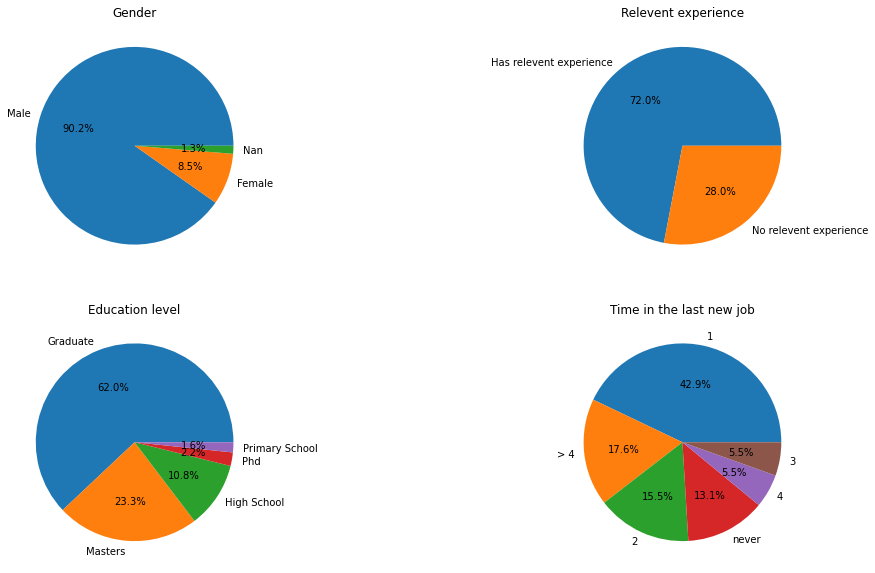

In [6]:
fig = plt.figure(figsize = (18,10))

specs=gridspec.GridSpec(ncols = 2, nrows = 2, figure = fig)

ax1 = fig.add_subplot(specs[0,0],title = 'Gender') 
ax2 = fig.add_subplot(specs[0,1],title = 'Relevent experience') 
ax3 = fig.add_subplot(specs[1,0],title = 'Education level') 
ax4 = fig.add_subplot(specs[1,1],title = 'Time in the last new job') 

ax1.pie(train_data.gender.value_counts(), labels=['Male','Female','Nan'], autopct = '%1.1f%%')
ax2.pie(train_data.relevent_experience.value_counts(), labels = ['Has relevent experience','No relevent experience'], autopct = '%1.1f%%')
ax3.pie(train_data.education_level.value_counts(), labels = ['Graduate','Masters','High School','Phd','Primary School'], autopct = '%1.1f%%')
ax4.pie(train_data.last_new_job.value_counts(), labels = ['1','> 4','2','never','4','3'], autopct = '%1.1f%%');

We select these four variables to display a pie chart to analyse the amount of each category inside each variable. In the gender pie chart is clear that male is a predominant category. Note that an expressive percentual of candidates has relevant experience, around 72% off all. The predominant education level is graduate, following by masters and high school, respectively. In the last chart, we see that the majority of candidates have 1 year of experience in their last job.

Crossing of variables with the "target" variable.

In [7]:
gen_targ = pd.crosstab(train_data.gender, train_data.target, margins = True).drop(index = 'All', columns='All')
rev_exp_targ = pd.crosstab(train_data.relevent_experience, train_data.target,margins = True).drop(index = 'All', columns = 'All')
edu_lvl_targ = pd.crosstab(train_data.education_level, train_data.target,margins = True).drop(index = 'All', columns = 'All')
las_job_targ = pd.crosstab(train_data.last_new_job, train_data.target,margins = True).drop(index = 'All', columns = 'All')

Visualization of the crossing of previously made information.

<AxesSubplot:xlabel='last_new_job', ylabel='value'>

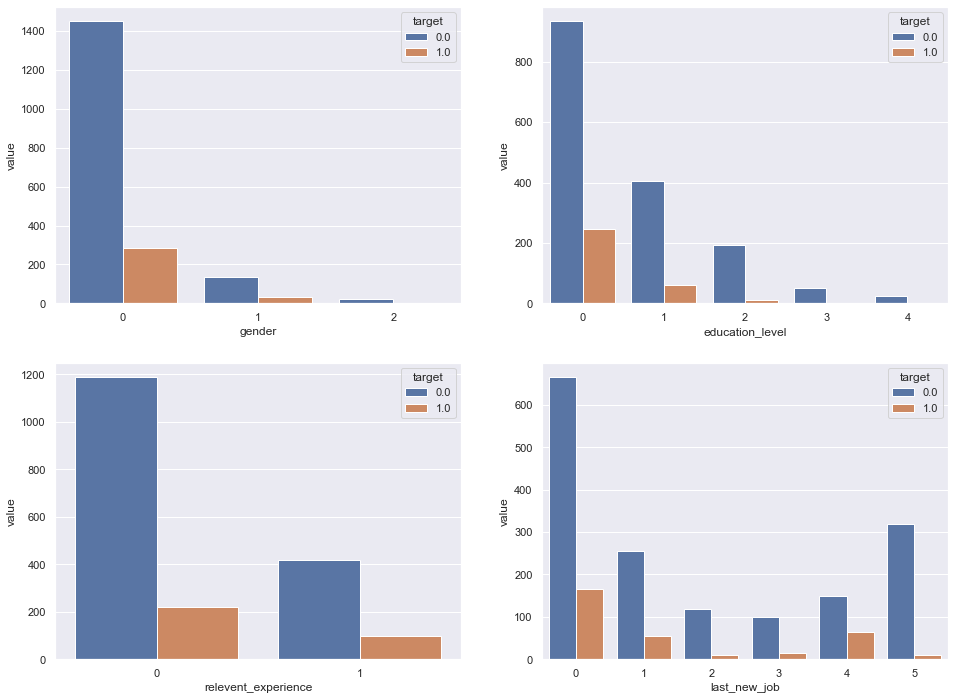

In [38]:

stacked1 = gen_targ.stack().reset_index().rename(columns = {0:'value'})
stacked2 = rev_exp_targ.stack().reset_index().rename(columns = {0:'value'})
stacked3 = edu_lvl_targ.stack().reset_index().rename(columns = {0:'value'})
stacked4 = las_job_targ.stack().reset_index().rename(columns = {0:'value'})


fig, axs = plt.subplots(nrows=2,ncols=2)
sns.set(rc = {'figure.figsize':(16,12)})
sns.barplot(x = stacked1.gender, y = stacked1.value, hue = stacked1.target, ax = axs[0,0])
sns.barplot(x = stacked2.relevent_experience, y = stacked2.value, hue=stacked2.target, ax = axs[1,0])
sns.barplot(x = stacked3.education_level, y = stacked3.value, hue=stacked3.target, ax = axs[0,1])
sns.barplot(x = stacked4.last_new_job, y = stacked4.value, hue=stacked4.target, ax = axs[1,1])

In [9]:
train_data.training_hours.describe()

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

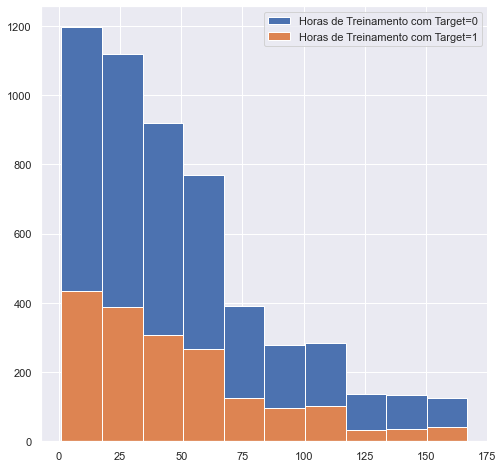

In [10]:
fig = plt.figure(figsize = (8,8))
plt.hist(train_data[(train_data.training_hours) & (train_data.target == 0)].training_hours,label = 'Horas de Treinamento com Target=0')
plt.hist(train_data[(train_data.training_hours) & (train_data.target == 1)].training_hours,label = 'Horas de Treinamento com Target=1')
plt.legend(loc = 'upper right')
plt.show()

### Verify data quality

Finding missing values

In [11]:
train_data = pd.concat([train_data,test_data], axis = 0).reset_index(drop = True)

In [12]:
print("\t amount of existing null values \n \n ",train_data.isnull().sum())

	 amount of existing null values 
 
  enrollee_id                  0
city                         0
city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline          3125
experience                  70
company_size              6560
company_type              6774
last_new_job               463
training_hours               0
target                    2129
dtype: int64


In [13]:
print("\t Percent of Null Values \n \n ",
      100*train_data.isnull().sum()/len(train_data))

	 Percent of Null Values 
 
  enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.563677
relevent_experience        0.000000
enrolled_university        1.958942
education_level            2.405224
major_discipline          14.680321
experience                 0.328839
company_size              30.816931
company_type              31.822239
last_new_job               2.175036
training_hours             0.000000
target                    10.001409
dtype: float64


## Data Preparation

We remove from the dataset the rows of the columns that have little missing data.

In [14]:
train_data.dropna(subset = ["experience"], inplace = True)
train_data.dropna(subset = ["enrolled_university"], inplace = True)
train_data.dropna(subset = ["last_new_job"], inplace = True)
train_data.dropna(subset = ["education_level"], inplace = True)

Filling in the missing values

In [15]:

#major_discipline
train_data["major_discipline"].fillna( method ='ffill', limit = 3, inplace = True)
train_data.dropna(subset = ["major_discipline"], inplace=True) # retira o resto dos valores faltantes não preenchidos

#company_size
train_data["company_size"].fillna( method ='ffill', limit = 2, inplace = True)
train_data.dropna(subset = ["company_size"], inplace=True)

#company_type
train_data["company_type"].fillna( method ='ffill', limit = 2, inplace = True)
train_data.dropna(subset = ["company_type"], inplace=True)

#gender
train_data["gender"].fillna( method ='ffill', limit = 2, inplace = True)
train_data.dropna(subset = ["gender"], inplace=True)


Numerical representation for categorical data

In [16]:
# gender
# male = 0 , female = 1, other = 2
train_data["gender"] = [ 0 if gender == "Male"
                        else 1 if gender == "Female"
                        else 2 for gender in train_data["gender"]]

# has relevent experience = 0 , No relevent experience = 1
train_data["relevent_experience"] = [ 0 if i == "Has relevent experience"
                                    else 1 for i in train_data["relevent_experience"]]

# enrolled_university 
# no_enrollment = 0 , Full time course = 1, Part time course = 2
train_data["enrolled_university"] = [ 0 if i == "no_enrollment"
                                    else 1 if i == "Full time course"
                                    else 2 for i in train_data["enrolled_university"]]

# education_level
# Graduate = 0 , Masters = 1, High School = 2, Phd = 3, Primary School = 4 
train_data["education_level"] = [ 0 if i == "Graduate"
                                    else 1 if i == "Masters"
                                    else 2 if i == "High School"
                                    else 3 if i == "Phd" 
                                    else 4 for i in train_data["education_level"]]

# major_discipline 
# STEM  = 0 , Humanities = 1, Business Degree = 2, Arts = 3, No Major = 4, Other = 5 
train_data["major_discipline"] = [ 0 if i == "STEM"
                                    else 1 if i == "Humanities"
                                    else 2 if i == "Business Degree"
                                    else 3 if i == "Arts" 
                                    else 4 if i == "No Major" 
                                    else 5 for i in train_data["major_discipline"]]
# experience
train_data["experience"] = [ 0 if i == "2" or i == "1" or i == "4" or i == "<1" or i == "3"
                                    else 1 if i == "5>" or i == "11" or i == "7" or i == "10" or i == "6" or i == "9" or i == "8" or i == "20"
                                    else 2 for i in train_data["experience"]]
# company_size
train_data["company_size"] = [ 0 if i == "10/49"
                                    else 1 for i in train_data["company_size"]]
#company_type
# pvt ltd = 0, Funded Startup  = 1 , Public Sector  = 2, Early Stage Startup = 3, NGO = 4 , else 5 
train_data["company_type"] = [ 0 if i == "Pvt Ltd"
                               else 1 if i == "Funded Startup"
                               else 2 if i == "Public Sector"
                               else 3 if i == "Early Stage Startup"
                               else 4 if i == "NGO" 
                               else 5 for i in train_data["company_type"]]

train_data["company_type"] = [ 0 if i == 3 or i == 4
                               else 1 if i == 2
                               else 2 for i in train_data["company_type"]]

# last_new_job
train_data["last_new_job"] = [ 0 if i == "1"
                               else 1 if i == "2"
                               else 2 if i == "3"
                               else 3 if i == "4"
                               else 4 if i == "never" 
                               else 5 for i in train_data["last_new_job"]]
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,0,1,0,0,0,2,1,2,5,47,0.0
2,11561,city_21,0.624,0,1,1,0,0,2,1,2,4,83,0.0
4,666,city_162,0.767,0,0,0,1,0,2,1,2,3,8,0.0
5,21651,city_176,0.764,0,0,2,0,0,1,1,2,0,24,1.0
6,28806,city_160,0.920,0,0,0,2,0,2,1,2,0,24,0.0


In [17]:
#city
le = LabelEncoder()
train_data["city"] = le.fit_transform(train_data["city"])
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,77,0.776,0,1,0,0,0,2,1,2,5,47,0.0
2,11561,64,0.624,0,1,1,0,0,2,1,2,4,83,0.0
4,666,50,0.767,0,0,0,1,0,2,1,2,3,8,0.0
5,21651,57,0.764,0,0,2,0,0,1,1,2,0,24,1.0
6,28806,49,0.920,0,0,0,2,0,2,1,2,0,24,0.0


## Modelling

In [18]:
train_data = train_data.reset_index(drop=True)
test = train_data[17248:]
test.drop(labels = ["target","enrollee_id"],axis = 1, inplace = True);
train = train_data[:17248]
train.drop(labels = ["enrollee_id"],axis = 1, inplace = True);

C:\Users\lucianogarim\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
X = train.drop(labels = "target", axis = 1)
y = train["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print("X_train", len(X_train))
print("X_test", len(X_test))
print("y_train", len(y_train))
print("y_test", len(y_test))
print("test", len(test))

X_train 13798
X_test 3450
y_train 13798
y_test 3450
test 1930


Above we will use two machine learnig algorithms, in order to find what is the best one for our problem. We test different parameters and measure the quality of our solution looking at the accuracy metric.

### K-nearest neighbours

In [20]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.score(X_test,y_test)


0.7602898550724637

Model Evaluation (K-nearest neighbours)

<AxesSubplot:>

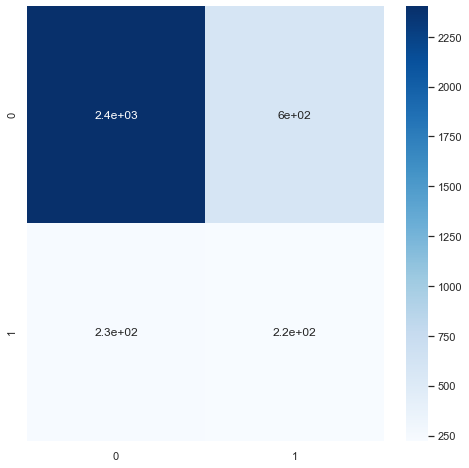

In [21]:
cm = confusion_matrix(clf.predict(X_test), y_test)
fig = plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'Blues')

Testing Parameters (K-nearest neighbours)

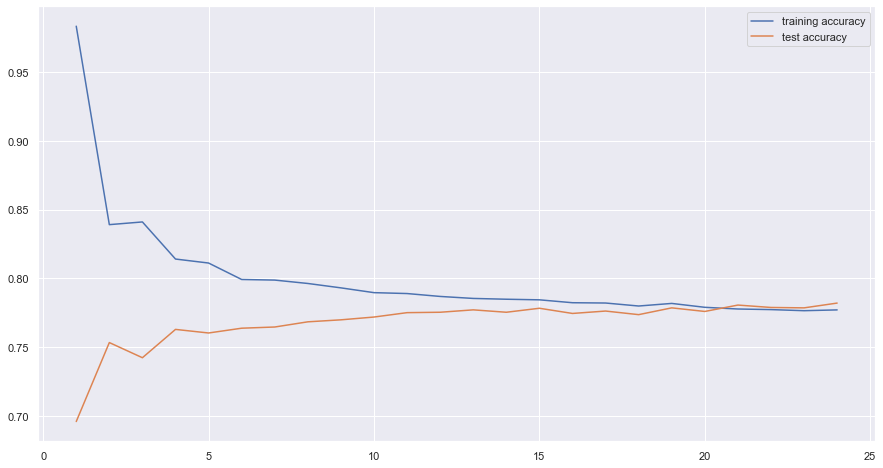

In [22]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,25)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(X_train,y_train)
    training_accuracy.append(clf.score(X_train,y_train))
    test_accuracy.append(clf.score(X_test,y_test))
    
fig = plt.figure(figsize = (15,8))    
plt.plot(neighbors_settings,training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings,test_accuracy, label = "test accuracy")
plt.legend()

In [23]:
max_value = max(test_accuracy)
max_index = test_accuracy.index(max_value)
print('Max:',max_value)
print('Index:',max_index)
print('Best n_neighbors:', max_index+1)

Max: 0.7820289855072464
Index: 23
Best n_neighbors: 24


Executing the model with the best parameter.

In [24]:
clf = KNeighborsClassifier(n_neighbors = max_index+1)
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

0.7820289855072464

<AxesSubplot:>

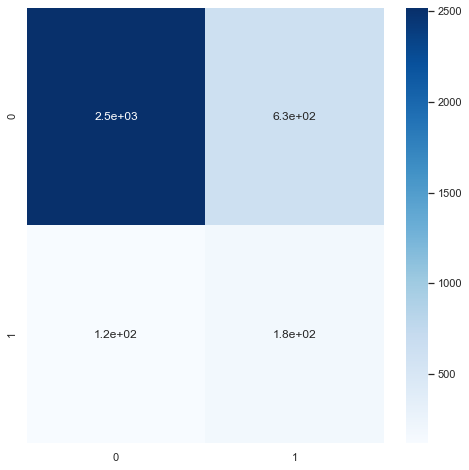

In [25]:
cm = confusion_matrix(clf.predict(X_test), y_test)
fig = plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'Blues')

### Random Forest

In [26]:
result = []

random_forest_model = RandomForestClassifier(max_depth=3, random_state= 43)
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)

acc_random_forest = accuracy_score(y_test, y_pred_random_forest)
result.append(acc_random_forest)

print("RESULT")
print("Random Forest Model Acc : ", acc_random_forest)

RESULT
Random Forest Model Acc :  0.767536231884058


Model Evaluation (Random Forest)

<AxesSubplot:>

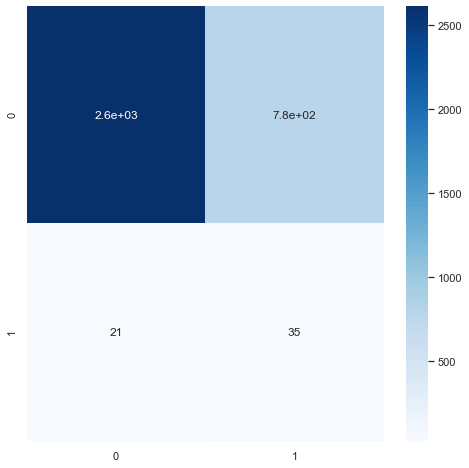

In [27]:
cm_random_forest = confusion_matrix(y_pred_random_forest, y_test)

fig = plt.figure(figsize = (8,8))
sns.heatmap(cm_random_forest, annot = True, cmap = 'Blues')

Testing Parameters (Random Forest)
         
         Test with max_depth

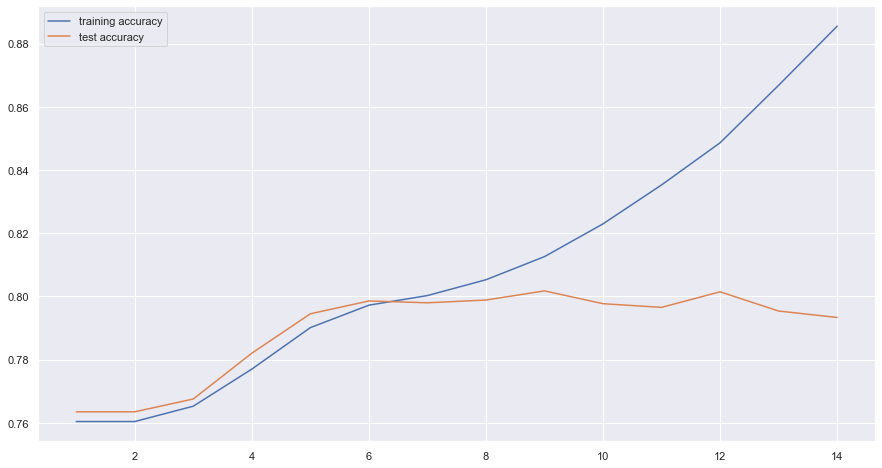

In [28]:
training_accuracy = []
test_accuracy = []
max_depths = range(1,15)
random_state = 43

for max_depth in max_depths:
    random_forest_model = RandomForestClassifier(max_depth = max_depth, random_state = random_state)
    random_forest_model.fit(X_train, y_train)
    y_pred_random_forest = random_forest_model.predict(X_test)
    y_pred_random_forests = random_forest_model.predict(X_train)
    training_accuracy.append(accuracy_score( y_pred_random_forests ,y_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_random_forest))
    
fig = plt.figure(figsize = (15,8))    
plt.plot(max_depths,training_accuracy, label = "training accuracy")
plt.plot(max_depths,test_accuracy, label = "test accuracy")
plt.legend()

In [29]:
max_value = max(test_accuracy)
max_index = test_accuracy.index(max_value)
print('Max:', max_value)
print('Index:', max_index)
print('Best max_depth:', max_index+1)

Max: 0.8017391304347826
Index: 8
Best max_depth: 9


Executing the model with the best parameter.

<AxesSubplot:>

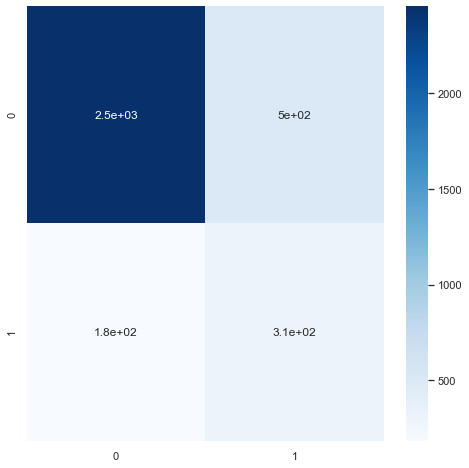

In [30]:
result = []

random_forest_model = RandomForestClassifier(max_depth = max_index+1, random_state = 43)
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)

acc_random_forest = accuracy_score(y_test, y_pred_random_forest)
result.append(acc_random_forest)

cm_random_forest = confusion_matrix(y_pred_random_forest, y_test)

fig = plt.figure(figsize = (8,8))
sns.heatmap(cm_random_forest, annot = True, cmap = 'Blues')

## Evaluation

Here, we will use the test dataset in our best model, and look at relation between key variables and the targe predicted by our algorithm.

In [31]:
y_pred_random_forest = random_forest_model.predict(test)
test['target'] = y_pred_random_forest

<ipython-input-31-c778054f658d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = y_pred_random_forest


We will use the same plots that we have used before, but now with our prediction.

<AxesSubplot:xlabel='last_new_job', ylabel='value'>

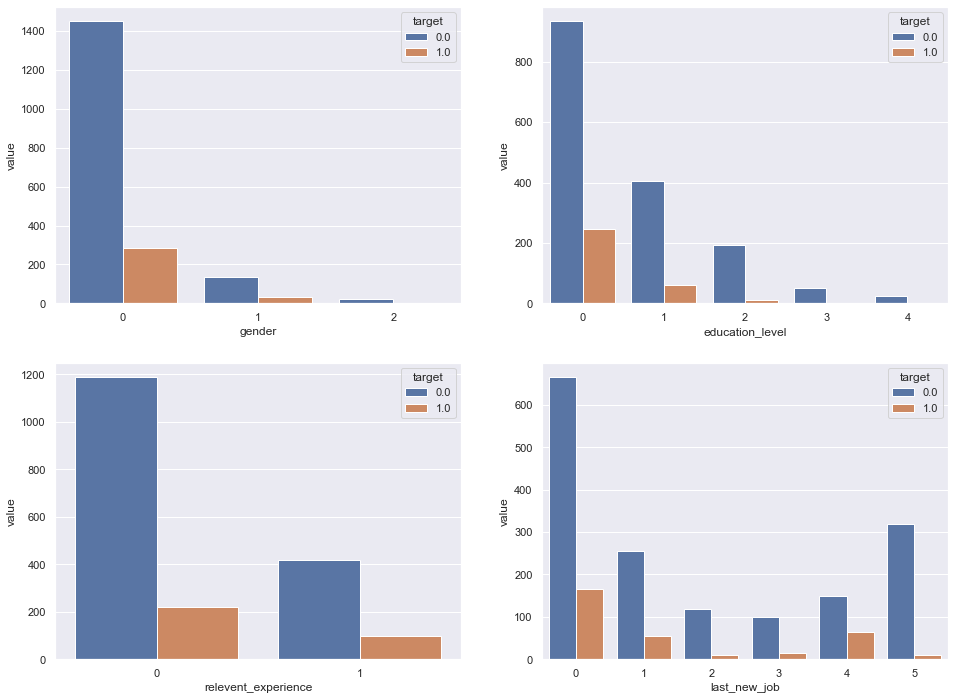

In [32]:
gen_targ = pd.crosstab(test.gender, test.target,margins = True).drop(index = 'All', columns = 'All')
rev_exp_targ = pd.crosstab(test.relevent_experience, test.target,margins = True).drop(index = 'All', columns = 'All')
edu_lvl_targ = pd.crosstab(test.education_level, test.target,margins = True).drop(index = 'All', columns = 'All')
las_job_targ = pd.crosstab(test.last_new_job, test.target,margins = True).drop(index = 'All', columns = 'All')

stacked1 = gen_targ.stack().reset_index().rename(columns = {0:'value'})
stacked2 = rev_exp_targ.stack().reset_index().rename(columns = {0:'value'})
stacked3 = edu_lvl_targ.stack().reset_index().rename(columns = {0:'value'})
stacked4 = las_job_targ.stack().reset_index().rename(columns = {0:'value'})


fig, axs = plt.subplots(nrows = 2,ncols = 2)
sns.set(rc = {'figure.figsize':(16,12)})
sns.barplot(x = stacked1.gender, y = stacked1.value, hue = stacked1.target, ax = axs[0,0])
sns.barplot(x = stacked2.relevent_experience, y=stacked2.value, hue=stacked2.target, ax = axs[1,0])
sns.barplot(x = stacked3.education_level, y = stacked3.value, hue = stacked3.target, ax = axs[0,1])
sns.barplot(x = stacked4.last_new_job, y = stacked4.value, hue = stacked4.target, ax = axs[1,1])

Looking at these last charts and comparing them with the first, we see the same trends, which implies the efficiency of our model. 

## Deployment

### Summary of key findings 

Here we will describe the main characteristics that influence the search for new jobs.

In [33]:
edu_lvl_targ_p = (edu_lvl_targ.loc[:,1]/(edu_lvl_targ.loc[:,0]+edu_lvl_targ.loc[:,1]))*100
print(round(edu_lvl_targ_p[0],2),'% of people with Graduate will look for a new job.')
print(round(edu_lvl_targ_p[1],2),'% of people with Master will look for a new job.')
print(round(edu_lvl_targ_p[2],2),'% of people with High School will look for a new job.')
print(round(edu_lvl_targ_p[3],2),'% of people with Phd or Primary School will look for a new job.')

20.85 % of people with Graduate will look for a new job.
13.25 % of people with Master will look for a new job.
6.31 % of people with High School will look for a new job.
0.0 % of people with Phd or Primary School will look for a new job.


In [34]:
rev_exp_targ_p = (rev_exp_targ.loc[:,1]/(rev_exp_targ.loc[:,0]+rev_exp_targ.loc[:,1]))*100
print('Around',round(rev_exp_targ_p[0],2),'% of people who have relevant experience will look for a new job.')
print('Around',round(rev_exp_targ_p[1],2),'% of people who have no relevant experience will look for a new job.')

Around 15.73 % of people who have relevant experience will look for a new job.
Around 19.08 % of people who have no relevant experience will look for a new job.


In [35]:
gen_targ_p = (gen_targ.loc[:,1]/(gen_targ.loc[:,0]+gen_targ.loc[:,1]))*100
print(round(gen_targ_p[0], 2),'% of women will look for a new job, while',round(gen_targ_p[1], 2),'% of men will look for a new job.')

16.52 % of women will look for a new job, while 19.05 % of men will look for a new job.


In [36]:
las_job_targ_p = (las_job_targ.loc[:,1]/(las_job_targ.loc[:,0]+las_job_targ.loc[:,1]))*100
print(round(las_job_targ_p[4], 2),'% of people who never worked will look for a new one')
print(round(las_job_targ_p[0], 2),'% of people who have 1 year since the previous job will look for a new one')
print('People who have more than 3 year since the previous job will look for a new one')

30.37 % of people who never worked will look for a new one
19.95 % of people who have 1 year since the previous job will look for a new one
People who have more than 3 year since the previous job will look for a new one


### Final report 

We opted by create a final report in a text file, summarizing our finds.

In [37]:
report= open("report.txt","w+")
report.write('FINAL REPORT ABOUT HR ANALYTICS: JOB CHANGE OF DATA SCIENTISTS \n \n')
report.write('Predictions made with Random Forest algorithm \n \n')
report.write('%d\r %% of people with Graduate will look for a new job.\n\n' % round(edu_lvl_targ_p[0],2))
report.write('%d\r %% people with Master will look for a new job.\n\n' % round(edu_lvl_targ_p[1],2))
report.write('%d\r %% of people with High School will look for a new job.\n\n' % round(edu_lvl_targ_p[2],2))
report.write('%d\r %% of people with Phd or Primary School will look for a new job.\n\n' % round(edu_lvl_targ_p[3],2))
report.write('%d\r %% of people who have relevant experience will look for a new job.\n\n' % round(rev_exp_targ_p[0],2))
report.write('%d\r %% of people who have no relevant experience will look for a new job.\n\n' % round(rev_exp_targ_p[1],2))
report.write('%d\r %% of women will look for a new job. \n\n' % round(gen_targ_p[0], 2))
report.write('%d\r %% of men will look for a new job. \n\n' % round(gen_targ_p[1], 2))
report.write('%d\r %% people who never worked will look for a new one.\n\n' % round(las_job_targ_p[4], 2))
report.write('%d\r %% of people who have 1 year since the previous job will look for a new one. \n\n' % round(las_job_targ_p[0], 2))
report.write('People who have more than 3 year since the previous job will look for a new one')
report.close()